# Week 2 Group 4
## PCA Missing Data
**TK8117**

**PhD. E.Odinsen, PhD. J.Jacobo, PhD. M.Windfeldt, PhD. M. Siddique, PhD. V. Reis**


# Agenda
1. PCA Missing Data - Case Study
2. Solutions Justification
   - Variables Explanation
   - Coding
3. Results
   - Plots
   - Interpretation

# 1 PCA & Missing Data
## What is PCA?
- Principal Component Analysis reduces dimensionality of data.
- Highlights patterns, correlations, and variance.

## Problem of Missing Data
- Missing values can distort PCA results.
- Our dataset: Air quality chemical multisensor device in an Italian city.

## Possible Solutions
There are different ways to deal with missing data, for the purpose of this work, it was decide to try the following techniques:
- Replace the missing (NaN) values with mean values;
- KNN 
- EM-PCA


# 2 Solutions Selected

## Solution 1
- Describe first solution for handling missing data.

## Solution 2
- Describe second solution for handling missing data.

## Solution 3
- Describe second solution for handling missing data.

## Variables Explanation
- Variable 1: ...
- Variable 2: ...
- Variable 3: ...

In [ ]:
# %%
# BLOCK 0 — Imports, global config, reproducibility
# What this block does: sets up libraries, plotting defaults, file path, and key knobs.
# Next: data loading & cleaning.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = False
RNG = np.random.default_rng(42)

CONFIG = {
    "DATA_PATH": "Copy of AirQualityUCI.csv",  # change path if needed
    "COLS": ["T","RH","AH","CO(GT)","NOx(GT)","NO2(GT)","C6H6(GT)","PT08.S1(CO)"],
    "TEST_FRAC": 0.10,          # fraction of observed cells to hide for scoring
    "NCOMP": 3,                 # number of PCs to keep/plot
    "KNN_NEIGHBORS": 5          # neighbors for KNN imputation
}



# Code & Results

## Raw data
For this work we used the Air quality data avaiable at the UC Irvine Machine Learning Repository.
Below, a brief summary of the dataset status:


In [13]:
# BLOCK 1 — Robust loader & cleaning
# What this block does:
# - Reads CSV/XLSX, fixes headers, drops junk columns, replaces sentinel -200→NaN.
# - Selects the variables for PCA; shows missingness percentages.
# Next: standardize and create the test-mask for fair evaluation.
def load_air_quality(path: str | Path) -> pd.DataFrame:
    path = Path(path)
    if path.suffix.lower() == ".xlsx":
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path)
        # If it collapses into one wide column, assume UCI semicolon CSV:
        if df.shape[1] == 1:
            df = pd.read_csv(path, sep=";", decimal=",", engine="python")
    # Tidy headers & drop unnamed
    df = df.loc[:, ~df.columns.str.contains("^Unnamed", na=False)]
    df.columns = (df.columns.str.strip()
                              .str.replace("\xa0"," ", regex=False)
                              .str.replace("\u200b","", regex=False))
    # Replace sentinel -200 with NaN
    return df.replace(-200, np.nan)

df_raw = load_air_quality(CONFIG["DATA_PATH"])
wanted = CONFIG["COLS"]
present = [c for c in wanted if c in df_raw.columns]
missing = [c for c in wanted if c not in df_raw.columns]
if missing:
    print("⚠️ Missing columns not found in file:", missing)
Xdf = df_raw[present].astype(float)
print("Rows:", len(Xdf))
print("Missing %:", (Xdf.isna().mean()*100).round(1).sort_values(ascending=False))

# Optional: month coloring for scatter plot if Date/Time exist
months = None
if {"Date","Time"}.issubset(df_raw.columns):
    dt = pd.to_datetime(df_raw["Date"] + " " + df_raw["Time"], errors="coerce", dayfirst=True)
    months = dt.dt.month.to_numpy()


Rows: 9471
Missing %: CO(GT)         19.0
NOx(GT)        18.5
NO2(GT)        18.5
T               5.1
RH              5.1
AH              5.1
C6H6(GT)        5.1
PT08.S1(CO)     5.1
dtype: float64


In [14]:
# %%
# BLOCK 2 — Standardize + Test-mask (entry-wise hold-out)
# What this block does:
# - Z-scores each column using NaN-aware mean/std (gaps ignored in stats).
# - Builds a test mask by hiding ~10% of originally observed cells (set to NaN).
#   We will grade only on these hidden cells—because we know their true values.
# Next: define PCA pipelines (Mean→PCA, KNN→PCA, EM-PCA).
def zscore_nan(X: np.ndarray):
    mu = np.nanmean(X, axis=0)
    sd = np.nanstd(X, axis=0, ddof=1)
    return (X - mu) / sd, mu, sd

def inv_zscore(Z, mu, sd):
    return Z * sd + mu

def make_test_mask(X: np.ndarray, frac=0.10, rng=RNG):
    obs = np.where(~np.isnan(X))         # indices of currently observed cells
    n = int(frac * obs[0].size)
    pick = rng.choice(obs[0].size, size=n, replace=False)
    mask = np.zeros_like(X, dtype=bool)  # True where we will hide & later score
    mask[obs[0][pick], obs[1][pick]] = True
    X_masked = X.copy()
    X_masked[mask] = np.nan
    return X_masked, mask

X = Xdf.to_numpy()
Z, mu, sd = zscore_nan(X)
Z_masked, test_mask = make_test_mask(Z, frac=CONFIG["TEST_FRAC"], rng=RNG)

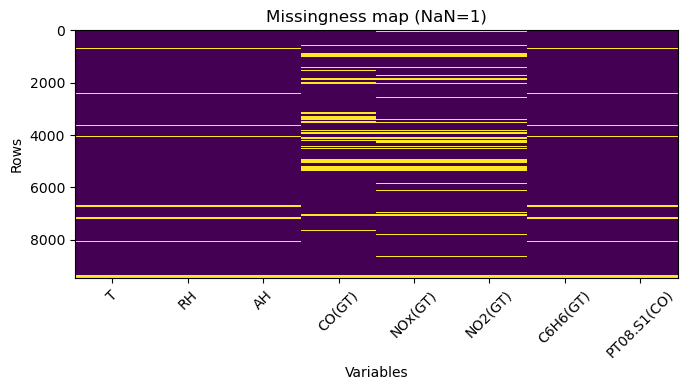

In [15]:
# %%
# BLOCK 6 — Plots for slides
# What this block does:
# - Missingness map (where NaNs are)
# - RMSE bar charts (raw & standardized)
# - Scree (cumulative EVR) to choose k
# - Loadings heatmap (interpret PCs physically)
# - PC1–PC2 scores (colored by month) + PC1 trend
# Next: optional outlier diagnostics (T² and Q).
def plot_missingness(X_, cols):
    plt.figure()
    plt.imshow(np.isnan(X_), aspect="auto", interpolation="nearest")
    plt.xticks(range(len(cols)), cols, rotation=45)
    plt.xlabel("Variables"); plt.ylabel("Rows"); plt.title("Missingness map (NaN=1)")
    plt.tight_layout(); plt.show()

def plot_rmse_bars(raw_vals, std_vals, labels):
    plt.figure()
    plt.bar(labels, std_vals)
    plt.ylabel("Standardized RMSE"); plt.title("Imputation accuracy (standardized)")
    for i, v in enumerate(std_vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout(); plt.show()

    plt.figure()
    plt.bar(labels, raw_vals)
    plt.ylabel("Raw RMSE (mixed units)"); plt.title("Imputation accuracy (raw)")
    for i, v in enumerate(raw_vals):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
    plt.tight_layout(); plt.show()

def plot_scree(evrs, labels):
    plt.figure()
    for evr, lab in zip(evrs, labels):
        x = np.arange(1, len(evr)+1)
        plt.plot(x, np.cumsum(evr), marker="o", label=lab)
    plt.xlabel("Number of PCs"); plt.ylabel("Cumulative explained variance")
    plt.title("Scree (cumulative EVR)"); plt.legend(); plt.tight_layout(); plt.show()

def plot_loadings(L, cols, ncomp_):
    plt.figure()
    plt.imshow(L[:, :ncomp_], aspect="auto", interpolation="nearest")
    plt.colorbar(); plt.yticks(range(len(cols)), cols)
    plt.xticks(range(ncomp_), [f"PC{i}" for i in range(1, ncomp_+1)])
    plt.title("Loadings (EM-PCA)"); plt.tight_layout(); plt.show()

def plot_scores_scatter(T_scores, months_):
    ok = ~np.isnan(T_scores).any(axis=1)
    plt.figure()
    if months_ is None:
        plt.scatter(T_scores[ok,0], T_scores[ok,1], s=6)
    else:
        sc = plt.scatter(T_scores[ok,0], T_scores[ok,1], c=months_[ok], s=6)
        cbar = plt.colorbar(sc); cbar.set_label("Month")
    plt.xlabel("PC1 score"); plt.ylabel("PC2 score"); plt.title("Scores (EM-PCA)")
    plt.tight_layout(); plt.show()

def plot_pc1_timeseries(T_scores):
    plt.figure()
    plt.plot(T_scores[:,0])
    plt.title("PC1 score over time (EM-PCA)")
    plt.xlabel("Row index"); plt.ylabel("PC1 score")
    plt.tight_layout(); plt.show()

# Draw the plots
plot_missingness(X, present)

As it can be seen, the poluent variables CO, NOx and NO2, are the main variables with missing values, with almost 1/5 of the rows having missing values. 
## PCA Code
With the data loaded, first we treat the data, creating the necessary functions to standardize the data and to create a masked group of data to later be used as a testing set.
The functions where defined as below:
```python
def zscore_nan(X: np.ndarray):
    mu = np.nanmean(X, axis=0)
    sd = np.nanstd(X, axis=0, ddof=1)
    return (X - mu) / sd, mu, sd

def inv_zscore(Z, mu, sd):
    return Z * sd + mu

def make_test_mask(X: np.ndarray, frac=0.10, rng=RNG):
    obs = np.where(~np.isnan(X))         # indices of currently observed cells
    n = int(frac * obs[0].size)
    pick = rng.choice(obs[0].size, size=n, replace=False)
    mask = np.zeros_like(X, dtype=bool)  # True where we will hide & later score
    mask[obs[0][pick], obs[1][pick]] = True
    X_masked = X.copy()
    X_masked[mask] = np.nan
    return X_masked, mask

X = Xdf.to_numpy()
Z, mu, sd = zscore_nan(X)
Z_masked, test_mask = make_test_mask(Z, frac=CONFIG["TEST_FRAC"], rng=RNG)
```


In [44]:
# %%
# BLOCK 3 — PCA pipelines (impute→PCA and EM-PCA)
# What this block does:
# - Defines 3 ways to deal with NaNs before/during PCA:
#   A) Mean→PCA (baseline), B) KNN→PCA (strong baseline), C) EM-PCA (handles NaNs directly).
# Next: run all pipelines and reconstruct to standardized space.
def pca_mean_impute(Zin, n_components=3):
    imp = SimpleImputer(strategy="mean")
    Zimp = imp.fit_transform(Zin)
    Zc = Zimp - Zimp.mean(axis=0, keepdims=True)
    pca = PCA(n_components=n_components, svd_solver="full", random_state=0)
    scores = pca.fit_transform(Zc)
    loadings = pca.components_.T
    Zrec = scores @ loadings.T + Zimp.mean(axis=0, keepdims=True)
    return Zrec, pca.explained_variance_ratio_, loadings, scores

def pca_knn_impute(Zin, n_components=3, n_neighbors=5):
    imp = KNNImputer(n_neighbors=n_neighbors, weights="distance")
    Zimp = imp.fit_transform(Zin)
    Zc = Zimp - Zimp.mean(axis=0, keepdims=True)
    pca = PCA(n_components=n_components, svd_solver="full", random_state=0)
    scores = pca.fit_transform(Zc)
    loadings = pca.components_.T
    Zrec = scores @ loadings.T + Zimp.mean(axis=0, keepdims=True)
    return Zrec, pca.explained_variance_ratio_, loadings, scores

def empca(Zin, n_components=3, max_iter=200, tol=1e-6):
    """
    EM-PCA: iteratively learns a low-rank PCA model and uses it to fill NaNs.
    E-step: reconstruct; M-step: refit PCA; update only missing cells; repeat.
    """
    Z = np.array(Zin, dtype=float, copy=True)
    nanmask = np.isnan(Z)
    # Init with column means (≈0 after z-scoring)
    col_means = np.nanmean(Z, axis=0)
    Z[nanmask] = np.take(col_means, np.where(nanmask)[1])

    prev_missing = Z[nanmask].copy()
    for _ in range(max_iter):
        mu_ = Z.mean(axis=0, keepdims=True)
        Zc = Z - mu_
        U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
        V = Vt.T[:, :n_components]
        T = U[:, :n_components] * S[:n_components]
        Zhat = T @ V.T + mu_
        Z[nanmask] = Zhat[nanmask]  # update missing only
        delta = float(np.sqrt(np.nanmean((Z[nanmask] - prev_missing)**2)))
        if delta < tol:
            break
        prev_missing = Z[nanmask].copy()

    # Final PCA on completed Z
    mu_ = Z.mean(axis=0, keepdims=True)
    Zc = Z - mu_
    U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
    V = Vt.T[:, :n_components]
    T = U[:, :n_components] * S[:n_components]
    Zhat = T @ V.T + mu_
    evr = (S[:n_components]**2) / (S**2).sum()
    return Z, Zhat, evr, V, T



With the basic tools needed to deal with the data all defined, we move to create the structure used to execute the PCA analysis. 
- Mean PCA

For the mean PCA approach, the following functions were constructed:
```python
def pca_mean_impute(Zin, n_components=3):
    imp = SimpleImputer(strategy="mean")
    Zimp = imp.fit_transform(Zin)
    Zc = Zimp - Zimp.mean(axis=0, keepdims=True)
    pca = PCA(n_components=n_components, svd_solver="full", random_state=0)
    scores = pca.fit_transform(Zc)
    loadings = pca.components_.T
    Zrec = scores @ loadings.T + Zimp.mean(axis=0, keepdims=True)
    return Zrec, pca.explained_variance_ratio_, loadings, scores
```
In this function, the missing values NaN in each column are replaced by the mean of the respective column. After that, the data is standardized to have mean zero and the PCA with 3 components is computed. 
To compute the PCA, we first set the PCA function from sklearn.decomposition with exact SVD method and the number of components 3. After computing the scores and loadings, the function returns, Zrec - Reconstructured Data, pca.explained_variance_ratio_ - The variance ratios, the loandings and the scores. 
- KNN PCA

```python
def pca_knn_impute(Zin, n_components=3, n_neighbors=5):
    imp = KNNImputer(n_neighbors=n_neighbors, weights="distance")
    Zimp = imp.fit_transform(Zin)
    Zc = Zimp - Zimp.mean(axis=0, keepdims=True)
    pca = PCA(n_components=n_components, svd_solver="full", random_state=0)
    scores = pca.fit_transform(Zc)
    loadings = pca.components_.T
    Zrec = scores @ loadings.T + Zimp.mean(axis=0, keepdims=True)
    return Zrec, pca.explained_variance_ratio_, loadings, scores
```
For the KNN–PCA approach, missing values are not replaced with simple column means. Instead, each NaN is estimated using the values from the 5 most similar rows (n_neighbors=5). Similarity is based on the other columns of the row with the missing value. The estimate is a weighted average of those neighbors, where closer rows have more influence.
After that, as standard, each column of the data is centered around the mean and the PCA is applied. The PCA is applied using the same tools as the mean PCA and returns the same variables. 

- EM-PCA
  
```python
def empca(Zin, n_components=3, max_iter=200, tol=1e-6):
    """
    EM-PCA: iteratively learns a low-rank PCA model and uses it to fill NaNs.
    E-step: reconstruct; M-step: refit PCA; update only missing cells; repeat.
    """
    Z = np.array(Zin, dtype=float, copy=True)
    nanmask = np.isnan(Z)
    # Init with column means (≈0 after z-scoring)
    col_means = np.nanmean(Z, axis=0)
    Z[nanmask] = np.take(col_means, np.where(nanmask)[1])

    prev_missing = Z[nanmask].copy()
    for _ in range(max_iter):
        mu_ = Z.mean(axis=0, keepdims=True)
        Zc = Z - mu_
        U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
        V = Vt.T[:, :n_components]
        T = U[:, :n_components] * S[:n_components]
        Zhat = T @ V.T + mu_
        Z[nanmask] = Zhat[nanmask]  # update missing only
        delta = float(np.sqrt(np.nanmean((Z[nanmask] - prev_missing)**2)))
        if delta < tol:
            break
        prev_missing = Z[nanmask].copy()

    # Final PCA on completed Z
    mu_ = Z.mean(axis=0, keepdims=True)
    Zc = Z - mu_
    U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
    V = Vt.T[:, :n_components]
    T = U[:, :n_components] * S[:n_components]
    Zhat = T @ V.T + mu_
    evr = (S[:n_components]**2) / (S**2).sum()
    return Z, Zhat, evr, V, T
```
The EM-PCA method is a iterative one. The code fist start applying the first method we implemented, the mean PCA, to reconstruct the data table, and replace the values that were filled in with the mean with the reconstructed values. With the data table reconstructed, the code applies the PCA once more, and the replace the filled values once again with the reconstructed values. This process continues over and over again, until the number of iterations exceeds the limit (max_iter=200), or the changes between the previous iteration values and the current one (delta = float(np.sqrt(np.nanmean((Z[nanmask] - prev_missing)**2)))) is smaller than the tolerance set (tol=1e-6).
Different from the previous funcionts, here empc() is defined such as that at each iteration, the SVD is calculated directly. Also, we have one more output. Here, empca() returns Z, the original data with the missing values replaced by the empca model, and Zhat, the whole table reconstructed using the pca model. 

In [24]:
# %%
# BLOCK 4 — Run all methods & reconstruct (standardized space)
# What this block does:
# - Runs Mean→PCA, KNN→PCA, and EM-PCA on the masked matrix.
# - Produces standardized reconstructions and (for EM) scores/loadings we’ll plot.
# Next: invert scaling to original units and compute metrics (RMSE & standardized RMSE).
ncomp = CONFIG["NCOMP"]
Zrec_A, evr_A, L_A, T_A = pca_mean_impute(Z_masked, n_components=ncomp)
Zrec_B, evr_B, L_B, T_B = pca_knn_impute(Z_masked, n_components=ncomp, n_neighbors=CONFIG["KNN_NEIGHBORS"])
Zcomp_C, Zrec_C, evr_C, L_C, T_C = empca(Z_masked, n_components=ncomp)
# %%
# BLOCK 5 — Metrics (RMSE & Standardized RMSE)
# What this block does:
# - Converts reconstructions back to original units.
# - Computes raw RMSE (mixed units) and standardized RMSE (unit-free, fair).
# Next: plots (missingness, RMSE bars, scree, loadings, scores, PC1 timeline).
def rmse_on_mask(yhat, ytrue, mask):
    return float(np.sqrt(np.nanmean((yhat[mask] - ytrue[mask])**2)))

def standardized_rmse(yhat, ytrue, mask, col_std):
    j = np.where(mask)[1]
    denom = np.where(col_std[j] == 0, 1.0, col_std[j])
    err_std = (yhat - ytrue)[mask] / denom
    return float(np.sqrt(np.mean(err_std**2)))

# back to original units
Xrec_A = inv_zscore(Zrec_A, mu, sd)
Xrec_B = inv_zscore(Zrec_B, mu, sd)
Xrec_C = inv_zscore(Zrec_C, mu, sd)

raw_A = rmse_on_mask(Xrec_A, X, test_mask)
raw_B = rmse_on_mask(Xrec_B, X, test_mask)
raw_C = rmse_on_mask(Xrec_C, X, test_mask)

std_cols = np.nanstd(X, axis=0, ddof=1)
srmse_A = standardized_rmse(Xrec_A, X, test_mask, std_cols)
srmse_B = standardized_rmse(Xrec_B, X, test_mask, std_cols)
srmse_C = standardized_rmse(Xrec_C, X, test_mask, std_cols)

In [ ]:
# %%
# BLOCK 4 — Run all methods & reconstruct (standardized space)
# What this block does:
# - Runs Mean→PCA, KNN→PCA, and EM-PCA on the masked matrix.
# - Produces standardized reconstructions and (for EM) scores/loadings we’ll plot.
# Next: invert scaling to original units and compute metrics (RMSE & standardized RMSE).
ncomp = CONFIG["NCOMP"]
Zrec_A, evr_A, L_A, T_A = pca_mean_impute(Z_masked, n_components=ncomp)
Zrec_B, evr_B, L_B, T_B = pca_knn_impute(Z_masked, n_components=ncomp, n_neighbors=CONFIG["KNN_NEIGHBORS"])
Zcomp_C, Zrec_C, evr_C, L_C, T_C = empca(Z_masked, n_components=ncomp)
# %%
# BLOCK 5 — Metrics (RMSE & Standardized RMSE)
# What this block does:
# - Converts reconstructions back to original units.
# - Computes raw RMSE (mixed units) and standardized RMSE (unit-free, fair).
# Next: plots (missingness, RMSE bars, scree, loadings, scores, PC1 timeline).
def rmse_on_mask(yhat, ytrue, mask):
    return float(np.sqrt(np.nanmean((yhat[mask] - ytrue[mask])**2)))

def standardized_rmse(yhat, ytrue, mask, col_std):
    j = np.where(mask)[1]
    denom = np.where(col_std[j] == 0, 1.0, col_std[j])
    err_std = (yhat - ytrue)[mask] / denom
    return float(np.sqrt(np.mean(err_std**2)))

# back to original units
Xrec_A = inv_zscore(Zrec_A, mu, sd)
Xrec_B = inv_zscore(Zrec_B, mu, sd)
Xrec_C = inv_zscore(Zrec_C, mu, sd)

raw_A = rmse_on_mask(Xrec_A, X, test_mask)
raw_B = rmse_on_mask(Xrec_B, X, test_mask)
raw_C = rmse_on_mask(Xrec_C, X, test_mask)

std_cols = np.nanstd(X, axis=0, ddof=1)
srmse_A = standardized_rmse(Xrec_A, X, test_mask, std_cols)
srmse_B = standardized_rmse(Xrec_B, X, test_mask, std_cols)
srmse_C = standardized_rmse(Xrec_C, X, test_mask, std_cols)


## Results
- Raw and Standardized RMSE:
    The first observation to be made is the importance of a standardized variables. In the table of variables we see that some variables such as AH changes from 0.185 to a maximum of 2.231, while others goes from 647 to 2040, both in completely different scales. So the Raw RMSE calculated, is heavily influenced by the scale of a few variables.
  

=== Variable ranges (min → max) ===
T               : -1.900 → 44.600
RH              : 9.200 → 88.700
AH              : 0.185 → 2.231
CO(GT)          : 0.100 → 11.900
NOx(GT)         : 2.000 → 1479.000
NO2(GT)         : 2.000 → 340.000
C6H6(GT)        : 0.100 → 63.700
PT08.S1(CO)     : 647.000 → 2040.000
=== === === === === === === === ===
Std. RMSE : Mean→PCA=0.628 | KNN→PCA=0.564 | EM-PCA=0.558
Raw RMSE  : Mean→PCA=64.50 | KNN→PCA=58.42 | EM-PCA=55.19


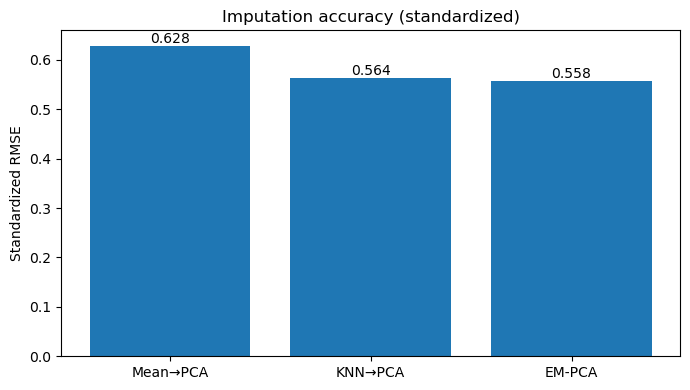

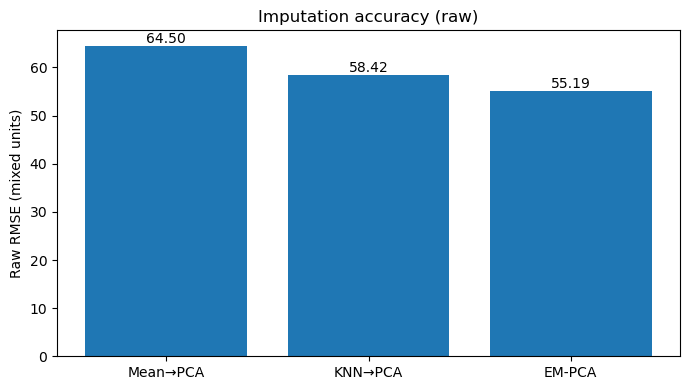

In [40]:
# BLOCK — Check min and max of each variable (ignoring NaNs)

print("=== Variable ranges (min → max) ===")
for col in present:   # 'present' comes from your Block 1 (the selected columns)
    col_min = np.nanmin(Xdf[col].to_numpy())
    col_max = np.nanmax(Xdf[col].to_numpy())
    print(f"{col:15s} : {col_min:.3f} → {col_max:.3f}")
print("=== === === === === === === === ===")
print(f"Std. RMSE : Mean→PCA={srmse_A:.3f} | KNN→PCA={srmse_B:.3f} | EM-PCA={srmse_C:.3f}")
print(f"Raw RMSE  : Mean→PCA={raw_A:.2f} | KNN→PCA={raw_B:.2f} | EM-PCA={raw_C:.2f}")
plot_rmse_bars([raw_A, raw_B, raw_C], [srmse_A, srmse_B, srmse_C], ["Mean→PCA","KNN→PCA","EM-PCA"])

Even though the RMSE calculated with the standardized data is more accurate and descriptive, the values shows that the implemented methods, when applied to a masked testing set, have a mediocre performance, with a the RMSE values between 0.558 and 0.628. Despise that, this is enough to show that the EM-PCA method have better results when compared to other methods.
 - Number of components:
   Moving to the accumulative explained variance, we ca once again see the better performance of the EM-PCA method, where with 3 components, it is able to explain more than 90% of the observed variance, justifying the choosing of the method and number of components. The tests for other numbers of components where omitted, since the objective is to compare the 3 methods in similar situations. 


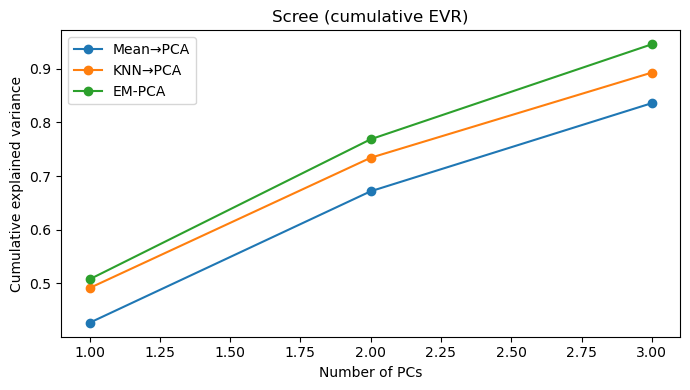

In [41]:
plot_scree([evr_A, evr_B, evr_C], ["Mean→PCA","KNN→PCA","EM-PCA"])

- Interpreting the PCA results: 

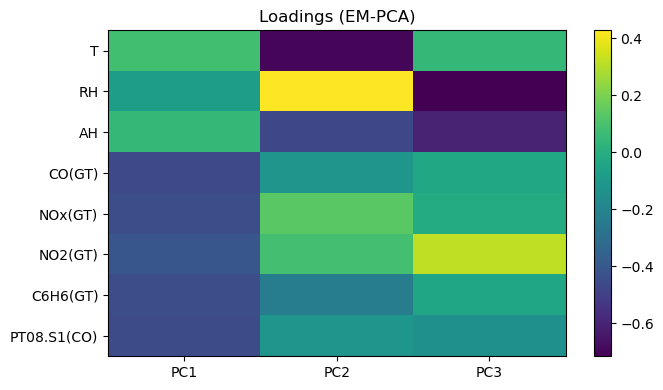

In [45]:
# BLOCK — Final PCA on full data (no artificial mask), then interpretation plots

# 1) Pick the best pipeline by standardized RMSE from the benchmarking step
methods = ["Mean→PCA", "KNN→PCA", "EM-PCA"]
srmse_vals = np.array([srmse_A, srmse_B, srmse_C], dtype=float)
best_idx = int(np.nanargmin(srmse_vals))
best_name = methods[best_idx]
# print(f"Best method from benchmark: {best_name} (Std-RMSE={srmse_vals[best_idx]:.3f})")

# 2) Re-run the winning method on the FULL standardized data Z (no test mask)
ncomp = CONFIG["NCOMP"]

def run_full(method_idx, Zfull):
    if method_idx == 0:  # Mean→PCA
        Zrec, evr, L, T = pca_mean_impute(Zfull, n_components=ncomp)
        return Zrec, evr, L, T
    elif method_idx == 1:  # KNN→PCA
        Zrec, evr, L, T = pca_knn_impute(Zfull, n_components=ncomp, n_neighbors=CONFIG["KNN_NEIGHBORS"])
        return Zrec, evr, L, T
    else:  # EM-PCA
        Zcomp, Zrec, evr, L, T = empca(Zfull, n_components=ncomp)
        return Zrec, evr, L, T

Zrec_full, evr_full, L_full, T_full = run_full(best_idx, Z)

# (Optional) If you want the full-data reconstruction in original units:
# Xrec_full = inv_zscore(Zrec_full, mu, sd)

# 3) Final interpretation plots (from the full-data run)
plot_loadings(L_full, present, ncomp)

The thermal map allows us to see that the first component (PC1), is influenced in two different directions. The pollutants all influence PC1 in a similar magnitude in the negative direction, while Absolute Humidity (AH) and Temperature (T) push PC1 in the positive direction, while relative humidity (RH) is closer to zero influence. But when we look at PC2, is clear that T and RH both are on the extreme influences for the component. And at last, the PC3 dont see much influence from the polluants, except NO2, and is more influenced by the humidity, both, absolute, and relative. 

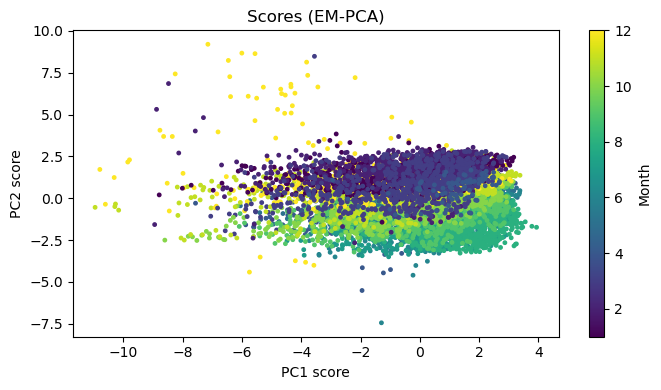

In [46]:
plot_scores_scatter(T_full, months)

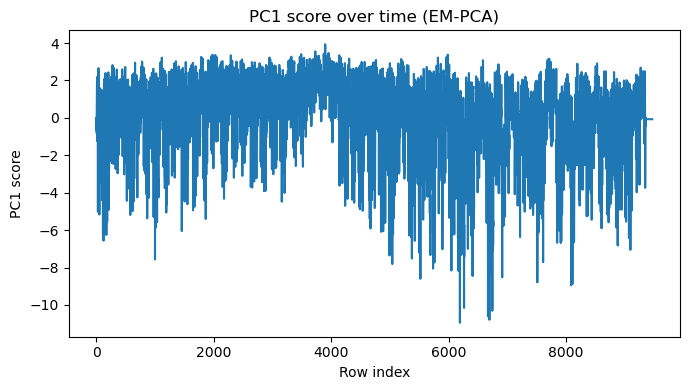

In [47]:
plot_pc1_timeseries(T_full)

In [31]:
# %%
# BLOCK 7 — Summary (print-ready bullets for slide notes)
# What this block does: prints the one-liners you can read on a slide.
print("\n=== One-liners for the talk ===")
print("• We converted -200→NaN, hid 10% known cells, then compared three pipelines.")
print("• EM-PCA reconstructed hidden values best (lowest Std-RMSE), KNN next, Mean last.")
print("• 2–3 PCs capture most structure (scree elbow); loadings map to thermo-moist & pollutant axes.")
print("• Scores show seasonality (summer right/down, winter left/up); residuals flag anomalies.")


=== One-liners for the talk ===
• We converted -200→NaN, hid 10% known cells, then compared three pipelines.
• EM-PCA reconstructed hidden values best (lowest Std-RMSE), KNN next, Mean last.
• 2–3 PCs capture most structure (scree elbow); loadings map to thermo-moist & pollutant axes.
• Scores show seasonality (summer right/down, winter left/up); residuals flag anomalies.
